<a href="https://colab.research.google.com/github/CarlosLaud/Juros/blob/main/TIMING_NTNB_PRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sistema de Análise de Títulos Públicos**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

In [ ]:
try:
    from bizdays import Calendar
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'bizdays'])
    from bizdays import Calendar

In [ ]:
class SistemaAnaliseTitulos:

    def __init__(self):
        """Inicializa o sistema com configurações e calendário"""
        self.calendar = self._criar_calendario()
        self.cache = {}

    def _criar_calendario(self):
        """Cria calendário brasileiro simplificado"""
        try:
            holidays = pd.read_excel(
                'http://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls',
                skipfooter=9
            )["Data"]
        except:
            holidays = pd.to_datetime([
                '2023-01-01', '2023-04-21', '2023-09-07', '2023-10-12', '2023-11-02', '2023-11-15', '2023-12-25',
                '2024-01-01', '2024-04-21', '2024-09-07', '2024-10-12', '2024-11-02', '2024-11-15', '2024-12-25',
                '2025-01-01', '2025-04-21', '2025-09-07', '2025-10-12', '2025-11-02', '2025-11-15', '2025-12-25'
            ])

        return Calendar(holidays, ["Saturday", "Sunday"])

    def consultar_bc_api(self, codigo_serie, data_inicio=None, data_fim=None):
        """Consulta API do Banco Central com tratamento robusto de erros"""
        cache_key = f"{codigo_serie}_{data_inicio}_{data_fim}"

        if cache_key in self.cache:
            print(f"📦 Usando cache para série {codigo_serie}")
            return self.cache[cache_key]

        try:
            if data_inicio and data_fim:
                url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=json&dataInicial={data_inicio}&dataFinal={data_fim}'
            else:
                url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=json'

            print(f"🔍 Consultando BC API - Série {codigo_serie}...")

            response = requests.get(url, timeout=30)
            response.raise_for_status()

            dados = response.json()
            df = pd.DataFrame(dados)

            if not df.empty:
                df['data'] = pd.to_datetime(df['data'], dayfirst=True)
                df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
                df = df.dropna()

                self.cache[cache_key] = df
                print(f"✅ {len(df)} registros obtidos da série {codigo_serie}")
                return df
            else:
                print(f"⚠️ Nenhum dado encontrado para série {codigo_serie}")
                return pd.DataFrame()

        except Exception as e:
            print(f"❌ Erro na consulta BC: {e}")
            return pd.DataFrame()

    def obter_curva_juros_real(self):
        """
        Obtém curva de juros real usando dados do Tesouro Direto
        Substitui simulação por dados reais
        """
        print("📈 Obtendo curva de juros real do Tesouro Direto...")

        try:
            # Carregar dados do Tesouro
            url = "https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv"
            df = pd.read_csv(url, sep=';', encoding='latin1', decimal=',')

            df['Data Base'] = pd.to_datetime(df['Data Base'], dayfirst=True)
            df['Data Vencimento'] = pd.to_datetime(df['Data Vencimento'], dayfirst=True)

            # Pegar última data
            ultima_data = df['Data Base'].max()
            df_atual = df[df['Data Base'] == ultima_data].copy()

            # Filtrar títulos prefixados
            prefixados = df_atual[df_atual['Tipo Titulo'].str.contains('Prefixado', na=False)].copy()

            if not prefixados.empty:
                # Calcular prazos em anos
                prefixados.loc[:, 'prazo_anos'] = (prefixados['Data Vencimento'] - ultima_data).dt.days / 365.25
                prefixados.loc[:, 'prazo_du'] = prefixados.apply(
                    lambda row: self.calendar.bizdays(ultima_data, row['Data Vencimento']), axis=1
                )

                # Limpar dados
                prefixados = prefixados.dropna(subset=['Taxa Venda Manha'])
                prefixados = prefixados[prefixados['prazo_anos'] > 0]

                # Ordenar por prazo
                curva = prefixados[['prazo_anos', 'prazo_du', 'Taxa Venda Manha']].copy()
                curva = curva.sort_values('prazo_anos')
                curva.columns = ['prazo_anos', 'prazo_du', 'taxa_aa']

                print(f"✅ Curva real obtida com {len(curva)} vértices")
                return curva
            else:
                print("⚠️ Nenhum título prefixado encontrado, usando curva simulada")
                return self._curva_simulada()

        except Exception as e:
            print(f"❌ Erro ao obter curva real: {e}")
            return self._curva_simulada()

    def _curva_simulada(self):
        """Curva simulada como fallback"""
        prazos_anos = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
        taxas_anuais = [10.5, 10.8, 11.0, 11.2, 11.5, 11.8, 12.0, 12.1, 12.2]

        return pd.DataFrame({
            'prazo_anos': prazos_anos,
            'taxa_aa': taxas_anuais,
            'prazo_du': [int(p * 252) for p in prazos_anos]
        })

    def gerar_spread_selic_pre(self, data_inicio='03/01/2019', data_fim='28/07/2025'):
        """
        Gera análise de spread com correção dos erros de indexação
        """
        print("📊 ANÁLISE SPREAD SELIC vs PRÉ-FIXADO")
        print("=" * 50)

        # 1. Obter dados da Selic
        df_selic = self.consultar_bc_api(12, data_inicio, data_fim)
        if df_selic.empty:
            print("❌ Falha ao obter dados da Selic")
            return pd.DataFrame(), None

        # 2. Processar Selic anualizada
        df_selic['selic_aa'] = ((df_selic['valor']/100 + 1)**252 - 1) * 100

        # 3. Obter curva real de juros
        df_curva = self.obter_curva_juros_real()

        # 4. Obter taxa pré de 1 ano REAL do Tesouro Direto
        try:
            print("🔍 Obtendo taxas pré reais do mercado...")

            # Carregar dados do Tesouro
            url = "https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv"
            df_tesouro = pd.read_csv(url, sep=';', encoding='latin1', decimal=',')

            df_tesouro['Data Base'] = pd.to_datetime(df_tesouro['Data Base'], dayfirst=True)
            df_tesouro['Data Vencimento'] = pd.to_datetime(df_tesouro['Data Vencimento'], dayfirst=True)

            # Filtrar prefixados próximos de 1 ano
            prefixados = df_tesouro[df_tesouro['Tipo Titulo'].str.contains('Prefixado', na=False)].copy()
            prefixados['prazo_anos'] = (prefixados['Data Vencimento'] - prefixados['Data Base']).dt.days / 365.25

            # Títulos entre 0.8 e 1.5 anos (próximos de 1 ano)
            pre_1ano = prefixados[
                (prefixados['prazo_anos'] >= 0.8) &
                (prefixados['prazo_anos'] <= 1.5)
            ].copy()

            if not pre_1ano.empty:
                # Calcular média por data para títulos próximos de 1 ano
                taxa_pre_serie = pre_1ano.groupby('Data Base')['Taxa Venda Manha'].mean().reset_index()
                taxa_pre_serie.columns = ['data', 'taxa_pre_1ano']

                # Merge com dados da Selic
                df_selic = df_selic.merge(taxa_pre_serie, on='data', how='left')

                # Interpolar valores faltantes
                df_selic['taxa_pre_1ano'] = df_selic['taxa_pre_1ano'].interpolate(method='linear')

                print(f"✅ {len(taxa_pre_serie)} observações de pré 1 ano obtidas")
            else:
                print("⚠️ Usando interpolação da curva para pré 1 ano")
                # Interpolar da curva
                if len(df_curva) >= 2:
                    interpolador = interp1d(df_curva['prazo_anos'], df_curva['taxa_aa'],
                                           kind='linear', fill_value='extrapolate')
                    taxa_pre_1ano = float(interpolador(1.0))
                    df_selic['taxa_pre_1ano'] = taxa_pre_1ano
                else:
                    df_selic['taxa_pre_1ano'] = 11.0  # Valor padrão

        except Exception as e:
            print(f"⚠️ Erro ao obter taxas reais: {e}")
            print("📊 Usando interpolação da curva...")

            if len(df_curva) >= 2:
                interpolador = interp1d(df_curva['prazo_anos'], df_curva['taxa_aa'],
                                       kind='linear', fill_value='extrapolate')
                taxa_pre_1ano = float(interpolador(1.0))
                df_selic['taxa_pre_1ano'] = taxa_pre_1ano
            else:
                df_selic['taxa_pre_1ano'] = 11.0

        # 5. Calcular spread
        df_selic['spread'] = df_selic['taxa_pre_1ano'] - df_selic['selic_aa']

        # 6. Plotar gráfico
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=(12, 6))
        fig.suptitle('Taxa Pré de 1 Ano vs Selic (Dados Reais)', fontsize=19, fontweight='bold')

        ax.plot(df_selic['data'], df_selic['selic_aa'],
               color='blue', linewidth=2, label='Selic')
        ax.plot(df_selic['data'], df_selic['taxa_pre_1ano'],
               color='red', linewidth=1, label='Pré 1 ano (Tesouro)')

        ax.set_ylim(bottom=0)
        ax.legend(loc=[.1, .7])

        # Spread
        ax2 = ax.twinx()
        ax2.fill_between(df_selic['data'], 0, df_selic['spread'],
                        alpha=0.2, label='Spread', color='gray')
        ax2.set_ylabel('Spread', color='red')
        ax2.set_ylim(bottom=-3.6)
        ax2.legend(loc=[.1, .85])

        plt.tight_layout()
        plt.show()

        # Estatísticas
        print(f"\n📊 ESTATÍSTICAS:")
        print(f"📈 Selic atual: {df_selic['selic_aa'].iloc[-1]:.2f}%")
        print(f"📈 Pré 1 ano atual: {df_selic['taxa_pre_1ano'].iloc[-1]:.2f}%")
        print(f"📊 Spread atual: {df_selic['spread'].iloc[-1]:.2f}%")
        print(f"📊 Spread médio: {df_selic['spread'].mean():.2f}%")
        print(f"📊 Spread máximo: {df_selic['spread'].max():.2f}%")
        print(f"📊 Spread mínimo: {df_selic['spread'].min():.2f}%")

        return df_selic, fig

    def calcular_vna_ipca(self, data_base='2000-06-01'):
        """
        Calcula VNA do IPCA com correção do erro de indexação
        """
        print("💹 Calculando VNA do IPCA...")

        # Obter IPCA via API
        ipca = self.consultar_bc_api(433)
        if ipca.empty:
            return pd.DataFrame()

        try:
            # Processar dados com correção da indexação
            ipca = ipca.set_index('data')

            # Filtrar a partir da data base
            data_base_dt = pd.to_datetime(data_base)
            ipca_filtrado = ipca[ipca.index >= data_base_dt].copy()

            if ipca_filtrado.empty:
                print(f"⚠️ Nenhum dado encontrado após {data_base}")
                return pd.DataFrame()

            # Calcular IPCA acumulado - CORREÇÃO DO ERRO
            ipca_acumulado = ((1 + ipca_filtrado['valor']/100).cumprod())

            # Criar DataFrame resultado
            resultado = pd.DataFrame(index=ipca_filtrado.index)
            resultado['ipca_acumulado'] = ipca_acumulado

            # Normalizar para base 1000 na data_base - CORREÇÃO DA INDEXAÇÃO
            if data_base_dt in ipca_acumulado.index:
                base_valor = ipca_acumulado.loc[data_base_dt]
            else:
                # Se data exata não existe, pegar a primeira disponível
                base_valor = ipca_acumulado.iloc[0]
                print(f"⚠️ Data exata {data_base} não encontrada, usando {ipca_acumulado.index[0].date()}")

            resultado['vna'] = 1000 * resultado['ipca_acumulado'] / base_valor

            # Ajustar datas (função original)
            def ajustar_data(data):
                if data.day == 1:
                    nova_data = data + pd.DateOffset(months=1)
                    return nova_data.replace(day=15)
                return data

            resultado.index = resultado.index.map(ajustar_data)

            print(f"✅ VNA calculado para {len(resultado)} períodos")
            print(f"📅 Período: {resultado.index.min().date()} a {resultado.index.max().date()}")

            return resultado

        except Exception as e:
            print(f"❌ Erro no cálculo VNA: {e}")
            return pd.DataFrame()

    def interpolacao_linear_datas(self, df_serie, data_pesquisada, coluna_valor):
        """Interpola valor entre datas com correção de erros"""
        try:
            if not isinstance(df_serie.index, pd.DatetimeIndex):
                df_serie.index = pd.to_datetime(df_serie.index)

            data_pesquisada = pd.to_datetime(data_pesquisada, dayfirst=True)

            pos = df_serie.index.searchsorted(data_pesquisada)

            if pos == 0:
                return df_serie.iloc[0][coluna_valor]
            elif pos >= len(df_serie):
                return df_serie.iloc[-1][coluna_valor]

            # Valores vizinhos
            data_ant = df_serie.index[pos - 1]
            data_seg = df_serie.index[pos]
            valor_ant = df_serie.iloc[pos - 1][coluna_valor]
            valor_seg = df_serie.iloc[pos][coluna_valor]

            # Interpolação usando dias corridos (mais simples)
            total_dias = (data_seg - data_ant).days
            dias_parcial = (data_pesquisada - data_ant).days

            if total_dias == 0:
                return valor_ant

            peso = dias_parcial / total_dias
            valor_interpolado = valor_ant + (valor_seg - valor_ant) * peso

            return valor_interpolado

        except Exception as e:
            print(f"❌ Erro na interpolação: {e}")
            return None

    def executar_analise_completa(self):
        """Executa análise completa com correções de erro"""
        print("🚀 SISTEMA DE ANÁLISE DE TÍTULOS - VERSÃO BETA")
        print("=" * 60)

        resultados = {}

        try:
            # 1. Análise Spread
            print("\n📊 1. ANÁLISE SPREAD SELIC vs PRÉ-FIXADO")
            df_spread, fig_spread = self.gerar_spread_selic_pre()
            resultados['spread_analysis'] = df_spread

        except Exception as e:
            print(f"❌ Erro na análise spread: {e}")
            resultados['spread_analysis'] = pd.DataFrame()

        try:
            # 2. Cálculo VNA IPCA
            print("\n📊 2. CÁLCULO VNA IPCA")
            vna_ipca = self.calcular_vna_ipca()

            if not vna_ipca.empty:
                valor_atual = vna_ipca['vna'].iloc[-1]
                data_atual = vna_ipca.index[-1]
                print(f"💰 VNA IPCA em {data_atual.strftime('%d/%m/%Y')}: {valor_atual:.2f}")

                resultados['vna_ipca'] = vna_ipca

                # 3. Teste de interpolação
                print("\n📊 3. TESTE DE INTERPOLAÇÃO")
                data_teste = '15/06/2024'
                valor_interpolado = self.interpolacao_linear_datas(vna_ipca, data_teste, 'vna')

                if valor_interpolado:
                    print(f"💹 VNA interpolado para {data_teste}: {valor_interpolado:.2f}")
                else:
                    print("⚠️ Não foi possível interpolar valor")

            else:
                print("❌ Não foi possível calcular VNA IPCA")
                resultados['vna_ipca'] = pd.DataFrame()

        except Exception as e:
            print(f"❌ Erro no cálculo VNA: {e}")
            resultados['vna_ipca'] = pd.DataFrame()

        print("\n✅ ANÁLISE FINALIZADA!")
        resultados['sistema_status'] = 'OK - Versão beta'

        return resultados




🚀 SISTEMA DE ANÁLISE DE TÍTULOS - VERSÃO BETA

📊 1. ANÁLISE SPREAD SELIC vs PRÉ-FIXADO
📊 ANÁLISE SPREAD SELIC vs PRÉ-FIXADO
🔍 Consultando BC API - Série 12...
✅ 1649 registros obtidos da série 12
📈 Obtendo curva de juros real do Tesouro Direto...
✅ Curva real obtida com 11 vértices
🔍 Obtendo taxas pré reais do mercado...
✅ 3892 observações de pré 1 ano obtidas


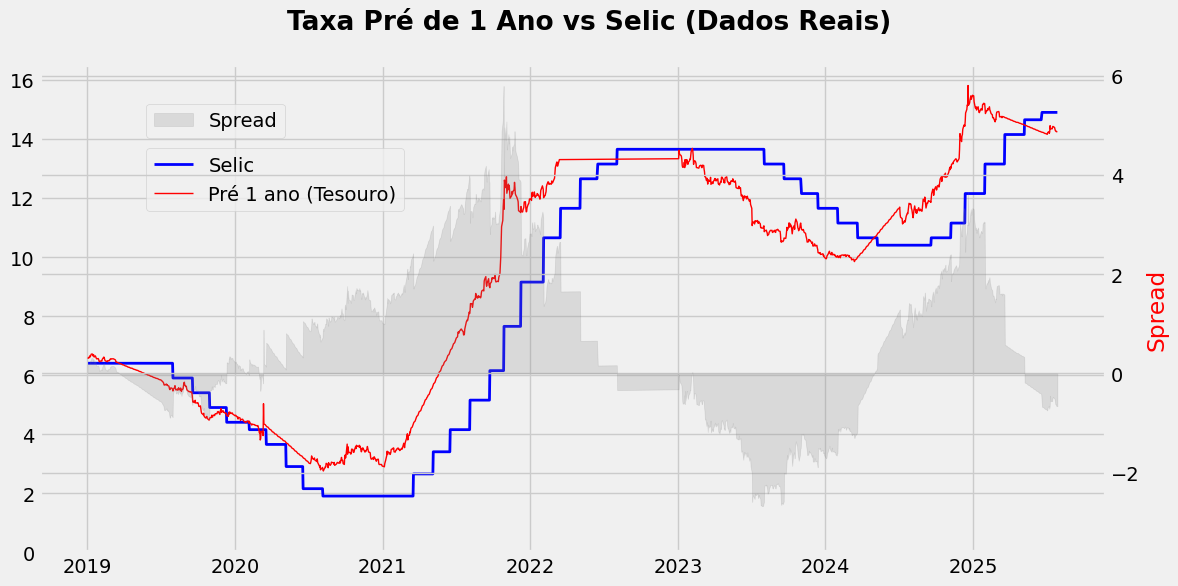


📊 ESTATÍSTICAS:
📈 Selic atual: 14.90%
📈 Pré 1 ano atual: 14.24%
📊 Spread atual: -0.66%
📊 Spread médio: 0.58%
📊 Spread máximo: 5.79%
📊 Spread mínimo: -2.67%

📊 2. CÁLCULO VNA IPCA
💹 Calculando VNA do IPCA...
🔍 Consultando BC API - Série 433...
✅ 546 registros obtidos da série 433
✅ VNA calculado para 302 períodos
📅 Período: 2000-07-15 a 2025-08-15
💰 VNA IPCA em 15/08/2025: 4541.06

📊 3. TESTE DE INTERPOLAÇÃO
💹 VNA interpolado para 15/06/2024: 4290.21

✅ ANÁLISE FINALIZADA!

🎉 Sistema operacional! Status: OK - Versão beta


In [ ]:
if __name__ == "__main__":
    sistema = SistemaAnaliseTitulos()
    resultados = sistema.executar_analise_completa()
    print(f"\n🎉 Sistema operacional! Status: {resultados['sistema_status']}")
else:
    print("📦 Sistema corrigido carregado!")
    print("💡 Use: sistema = SistemaAnaliseTitulos()")

**Análise de Títulos do Tesouro Direto - Versão com Seleção de Títulos**

In [ ]:
import subprocess
import sys

def instalar_dependencias():
    """Instala dependências necessárias no Google Colab"""
    dependencias = ['bizdays', 'python-dateutil', 'xlwings']

    for dep in dependencias:
        try:
            __import__(dep.replace('-', '_'))
        except ImportError:
            print(f"📦 Instalando {dep}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", dep])

# Instalar dependências
instalar_dependencias()


📦 Instalando python-dateutil...
📦 Instalando xlwings...


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from bizdays import Calendar
from IPython.display import Markdown
import warnings
warnings.filterwarnings('ignore')
# Dependências opcionais
try:
    import yfinance as yf
except ImportError:
    print("⚠️ yfinance não instalado. Instalando...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance as yf

try:
    import xlwings as xw
except ImportError:
    print("⚠️ xlwings não disponível no Colab (funciona apenas no Windows/Mac)")
    xw = None


In [ ]:
class AnalisadorTesouroDireto:
    """
    Classe para análise de títulos do Tesouro Direto com funcionalidades:
    - Consulta de dados do Banco Central
    - Análise de NTN-B por vencimento
    - Simulação de fluxos de caixa
    - Indexação pela Selic
    """

    def __init__(self):
        """Inicializa o analisador com configurações padrão"""
        self.calendar = self._criar_calendario_anbima()
        self.url_tesouro = "https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv"
        self.df_tesouro = None

    def _criar_calendario_anbima(self):
        """Cria calendário com feriados da ANBIMA"""
        try:
            print("📅 Carregando feriados da ANBIMA...")
            holidays = pd.read_excel(
                'http://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls',
                skipfooter=9
            )["Data"]
            weekends = ["Saturday", "Sunday"]
            cal = Calendar(holidays, weekends)
            print("✅ Calendário ANBIMA carregado com sucesso!")
            return cal
        except Exception as e:
            print(f"⚠️ Erro ao carregar feriados ANBIMA: {e}")
            print("📅 Usando calendário básico...")
            feriados_basicos = [
                '2023-01-01', '2023-04-21', '2023-09-07', '2023-10-12', '2023-11-02', '2023-11-15', '2023-12-25',
                '2024-01-01', '2024-04-21', '2024-09-07', '2024-10-12', '2024-11-02', '2024-11-15', '2024-12-25',
                '2025-01-01', '2025-04-21', '2025-09-07', '2025-10-12', '2025-11-02', '2025-11-15', '2025-12-25'
            ]
            holidays = pd.to_datetime(feriados_basicos)
            return Calendar(holidays, ["Saturday", "Sunday"])

    def consultar_bc(self, codigo_bcb, data_ini=None, data_fim=None):
        """Consulta dados do Banco Central"""
        try:
            if data_ini and data_fim:
                url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json&dataInicial={data_ini}&dataFinal={data_fim}'
            else:
                url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json'

            print(f"🔍 Consultando BC - Série {codigo_bcb}...")
            df = pd.read_json(url)
            df['data'] = pd.to_datetime(df['data'], dayfirst=True)
            print(f"✅ {len(df)} registros obtidos")
            return df

        except Exception as e:
            print(f"❌ Erro na consulta BC: {e}")
            return pd.DataFrame()

    def carregar_dados_tesouro(self):
        """Carrega dados do Tesouro Direto"""
        try:
            print("📊 Carregando dados do Tesouro Direto...")
            df = pd.read_csv(self.url_tesouro, sep=';', encoding='latin1', decimal=',')

            # Conversões de data
            df['Data Base'] = pd.to_datetime(df['Data Base'], dayfirst=True)
            df['Data Vencimento'] = pd.to_datetime(df['Data Vencimento'], dayfirst=True)

            self.df_tesouro = df
            ultima_data = df['Data Base'].max().date()
            total_registros = len(df)

            print(f"✅ {total_registros:,} registros carregados")
            print(f"📅 Última data disponível: {ultima_data}")

            return df

        except Exception as e:
            print(f"❌ Erro ao carregar dados: {e}")
            return pd.DataFrame()

    def listar_titulos_ipca_disponiveis(self):
        """
        Lista todos os títulos IPCA+ disponíveis por vencimento

        Returns:
            DataFrame: Títulos IPCA+ únicos com informações
        """
        if self.df_tesouro is None:
            self.carregar_dados_tesouro()

        # Filtrar apenas Tesouro IPCA+
        df_ipca = self.df_tesouro[
            self.df_tesouro['Tipo Titulo'] == 'Tesouro IPCA+'
        ].copy()

        if df_ipca.empty:
            print("⚠️ Nenhum título IPCA+ encontrado")
            return pd.DataFrame()

        # Obter última data para cada vencimento
        ultima_data = df_ipca['Data Base'].max()
        df_atual = df_ipca[df_ipca['Data Base'] == ultima_data]

        # Agrupar por vencimento
        titulos_unicos = df_atual.groupby('Data Vencimento').agg({
            'Taxa Compra Manha': 'mean',
            'Taxa Venda Manha': 'mean',
            'PU Compra Manha': 'mean',
            'PU Venda Manha': 'mean'
        }).reset_index()

        # Calcular dias úteis até vencimento
        titulos_unicos['DU_Vencimento'] = titulos_unicos['Data Vencimento'].apply(
            lambda x: self.calendar.bizdays(ultima_data, x)
        )

        # Calcular anos até vencimento
        titulos_unicos['Anos_Vencimento'] = titulos_unicos['DU_Vencimento'] / 252

        # Formatação para exibição
        titulos_unicos['Vencimento_Str'] = titulos_unicos['Data Vencimento'].dt.strftime('%d/%m/%Y')

        # Ordenar por data de vencimento
        titulos_unicos = titulos_unicos.sort_values('Data Vencimento').reset_index(drop=True)

        print(f"📋 TÍTULOS IPCA+ DISPONÍVEIS ({len(titulos_unicos)} opções)")
        print("=" * 80)

        for idx, titulo in titulos_unicos.iterrows():
            print(f"🏷️  [{idx}] Vencimento: {titulo['Vencimento_Str']} "
                  f"({titulo['Anos_Vencimento']:.1f} anos)")
            print(f"    💰 Taxa Compra: {titulo['Taxa Compra Manha']:.2f}% a.a. | "
                  f"PU Compra: R$ {titulo['PU Compra Manha']:.2f}")
            print(f"    💰 Taxa Venda: {titulo['Taxa Venda Manha']:.2f}% a.a. | "
                  f"PU Venda: R$ {titulo['PU Venda Manha']:.2f}")
            print()

        return titulos_unicos

    def selecionar_titulo_por_indice(self, indice):
        """
        Seleciona um título IPCA+ pelo índice da lista

        Args:
            indice (int): Índice do título na lista

        Returns:
            dict: Dados do título selecionado
        """
        titulos = self.listar_titulos_ipca_disponiveis()

        if titulos.empty:
            return {}

        if indice < 0 or indice >= len(titulos):
            print(f"❌ Índice inválido. Escolha entre 0 e {len(titulos)-1}")
            return {}

        titulo_selecionado = titulos.iloc[indice]
        data_vencimento = titulo_selecionado['Data Vencimento']

        print(f"✅ TÍTULO SELECIONADO:")
        print(f"📅 Vencimento: {data_vencimento.strftime('%d/%m/%Y')}")
        print(f"💰 Taxa Compra: {titulo_selecionado['Taxa Compra Manha']:.2f}% a.a.")
        print(f"💰 PU Compra: R$ {titulo_selecionado['PU Compra Manha']:.2f}")

        return {
            'data_vencimento': data_vencimento,
            'taxa_compra': titulo_selecionado['Taxa Compra Manha'],
            'taxa_venda': titulo_selecionado['Taxa Venda Manha'],
            'pu_compra': titulo_selecionado['PU Compra Manha'],
            'pu_venda': titulo_selecionado['PU Venda Manha'],
            'anos_vencimento': titulo_selecionado['Anos_Vencimento'],
            'du_vencimento': titulo_selecionado['DU_Vencimento']
        }

    def selecionar_titulo_por_vencimento(self, data_vencimento):
        """
        Seleciona um título IPCA+ pela data de vencimento

        Args:
            data_vencimento (str): Data no formato 'YYYY-MM-DD' ou 'DD/MM/YYYY'

        Returns:
            dict: Dados do título selecionado
        """
        # Converter string para datetime
        try:
            if '/' in data_vencimento:
                data_venc = pd.to_datetime(data_vencimento, dayfirst=True)
            else:
                data_venc = pd.to_datetime(data_vencimento)
        except:
            print(f"❌ Formato de data inválido: {data_vencimento}")
            print("💡 Use formato 'DD/MM/YYYY' ou 'YYYY-MM-DD'")
            return {}

        titulos = self.listar_titulos_ipca_disponiveis()

        if titulos.empty:
            return {}

        # Buscar título com vencimento correspondente
        titulo_encontrado = titulos[titulos['Data Vencimento'] == data_venc]

        if titulo_encontrado.empty:
            print(f"❌ Nenhum título encontrado com vencimento {data_venc.strftime('%d/%m/%Y')}")
            print("💡 Títulos disponíveis:")
            for _, titulo in titulos.iterrows():
                print(f"   📅 {titulo['Data Vencimento'].strftime('%d/%m/%Y')}")
            return {}

        titulo_selecionado = titulo_encontrado.iloc[0]

        print(f"✅ TÍTULO ENCONTRADO:")
        print(f"📅 Vencimento: {data_venc.strftime('%d/%m/%Y')}")
        print(f"💰 Taxa Compra: {titulo_selecionado['Taxa Compra Manha']:.2f}% a.a.")
        print(f"💰 PU Compra: R$ {titulo_selecionado['PU Compra Manha']:.2f}")

        return {
            'data_vencimento': data_venc,
            'taxa_compra': titulo_selecionado['Taxa Compra Manha'],
            'taxa_venda': titulo_selecionado['Taxa Venda Manha'],
            'pu_compra': titulo_selecionado['PU Compra Manha'],
            'pu_venda': titulo_selecionado['PU Venda Manha'],
            'anos_vencimento': titulo_selecionado['Anos_Vencimento'],
            'du_vencimento': titulo_selecionado['DU_Vencimento']
        }

    def analisar_titulo_selecionado(self, titulo_info, data_ini_cdi='09/08/2023',
                                   data_fim_cdi='14/08/2025'):
        """
        Analisa um título IPCA+ específico indexado pela Selic

        Args:
            titulo_info (dict): Informações do título selecionado
            data_ini_cdi (str): Data inicial para CDI
            data_fim_cdi (str): Data final para CDI

        Returns:
            dict: Resultados da análise
        """
        if not titulo_info:
            print("❌ Informações do título não fornecidas")
            return {}

        data_vencimento = titulo_info['data_vencimento']
        data_venc_str = data_vencimento.strftime('%Y-%m-%d')

        print(f"📈 Analisando título IPCA+ com vencimento em {data_vencimento.strftime('%d/%m/%Y')}")

        # Filtrar dados históricos do título
        df_ipca = self.df_tesouro[
            (self.df_tesouro['Tipo Titulo'] == 'Tesouro IPCA+') &
            (self.df_tesouro['Data Vencimento'] == data_vencimento)
        ].copy()

        if df_ipca.empty:
            print(f"⚠️ Nenhum dado histórico encontrado para o título")
            return {}

        # Calcular dias úteis
        df_ipca['DU'] = -df_ipca['Data Base'].apply(
            lambda x: self.calendar.bizdays(data_vencimento, x)
        )

        # Calcular VNA
        colunas_interesse = ['Data Base', 'PU Compra Manha', 'Taxa Compra Manha', 'DU']
        df_ipca_clean = df_ipca[colunas_interesse].copy()
        df_ipca_clean['VNA'] = (
            (1 + df_ipca_clean['Taxa Compra Manha']/100)**(df_ipca_clean['DU']/252) *
            df_ipca_clean['PU Compra Manha']
        )

        df_ordenado = df_ipca_clean.sort_values(by='Data Base').set_index('Data Base')
        print(f"📊 {len(df_ordenado)} registros históricos processados")

        # Dados do CDI
        df_cdi = self.consultar_bc(12, data_ini_cdi, data_fim_cdi)
        if df_cdi.empty:
            return {}

        # Processar CDI
        print("🔄 Processando dados do CDI...")
        df_cdi['valor'] = df_cdi['valor']/100 + 1
        df_cdi['indice'] = [df_cdi.loc[i:, 'valor'].prod() for i in range(len(df_cdi))]
        df_cdi['VNA_cor'] = df_cdi['data'].map(df_ordenado['PU Compra Manha']) * df_cdi['indice']
        df_cdi = df_cdi.dropna()

        if not df_cdi.empty:
            data_max = df_cdi.loc[df_cdi['VNA_cor'].idxmax(), 'data']
            valor_max = df_cdi['VNA_cor'].max()

            print(f"📅 Data do valor máximo: {data_max.date()}")
            print(f"💰 Valor máximo: R$ {valor_max:.2f}")
        else:
            data_max = None
            valor_max = 0

        return {
            'titulo_info': titulo_info,
            'df_ntnb': df_ordenado,
            'df_cdi': df_cdi,
            'data_max': data_max,
            'valor_max': valor_max
        }

    def plotar_grafico_ntnb(self, df_cdi, titulo_info, data_inicio_grafico='2021-08-11',
                           data_fim_grafico='2025-08-14'):
        """Plota gráfico da NTN-B selecionada"""
        # Filtrar dados para o gráfico
        df_grafico = df_cdi[
            (df_cdi['data'] >= data_inicio_grafico) &
            (df_cdi['data'] <= data_fim_grafico)
        ].dropna()

        if df_grafico.empty:
            print("⚠️ Nenhum dado encontrado no período especificado para o gráfico")
            return

        print(f"📊 Plotando gráfico NTN-B com {len(df_grafico)} pontos")

        plt.figure(figsize=(14, 8))
        plt.plot(df_grafico['data'], df_grafico['VNA_cor'],
                label='NTN-B indexada Selic', linewidth=2, alpha=0.8, color='blue')

        plt.legend(fontsize=12)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Valor (R$)', fontsize=12)
        plt.title('NTN-B Indexada pela Selic', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    def plotar_tendencia(self, df_cdi, titulo_info, data_inicio_tendencia='2023-08-11',
                        data_fim_tendencia='2025-08-14'):
        """Plota linha de tendência para o título selecionado"""
        # Filtrar dados para tendência
        df_tendencia = df_cdi[
            (df_cdi['data'] >= data_inicio_tendencia) &
            (df_cdi['data'] <= data_fim_tendencia)
        ].dropna()

        if df_tendencia.empty:
            print("⚠️ Nenhum dado encontrado no período especificado para tendência")
            return {}

        vencimento_str = titulo_info['data_vencimento'].strftime('%d/%m/%Y')
        print(f"📈 Analisando tendência (Venc: {vencimento_str}) com {len(df_tendencia)} pontos")

        # Regressão linear
        X = np.arange(len(df_tendencia)).reshape(-1, 1)
        y = df_tendencia['VNA_cor'].values

        modelo = LinearRegression().fit(X, y)
        inclinacao = modelo.coef_[0]
        r2 = modelo.score(X, y)

        # Ajustar linha ao ponto máximo
        idx_max = np.argmax(y)
        x_max, y_max = X[idx_max][0], y[idx_max]
        intercepto_novo = y_max - inclinacao * x_max
        tendencia = inclinacao * X + intercepto_novo

        # Plotar
        plt.figure(figsize=(14, 8))
        plt.plot(df_tendencia['data'], df_tendencia['VNA_cor'],
                label=f'NTN-B indexada Selic (Venc: {vencimento_str})',
                linewidth=2, alpha=0.8, color='blue')
        plt.plot(df_tendencia['data'], tendencia,
                label='Linha de Tendência', linestyle='--', color='red', linewidth=2)

        plt.legend(fontsize=12)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Valor (R$)', fontsize=12)
        plt.title(f'Análise de Tendência - NTN-B (Venc: {vencimento_str})',
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return {
            'inclinacao': inclinacao,
            'r2': r2,
            'valor_min': y.min(),
            'valor_max': y.max(),
            'data_min': df_tendencia.iloc[np.argmin(y)]['data'],
            'data_max': df_tendencia.iloc[idx_max]['data']
        }

    def executar_analise_titulo_especifico(self, indice_titulo=None, data_vencimento=None,
                                          data_ini_cdi='01/01/2021', data_fim_cdi='14/08/2025',
                                          data_inicio_grafico='2021-08-11', data_fim_grafico='2025-08-14',
                                          data_inicio_tendencia='2023-08-11', data_fim_tendencia='2025-08-14'):
        """
        Executa análise completa para um título IPCA+ específico

        Args:
            indice_titulo (int, optional): Índice do título na lista
            data_vencimento (str, optional): Data de vencimento específica
            Outros parâmetros: datas para análise
        """
        print("🚀 ANÁLISE DE TÍTULO IPCA+ ESPECÍFICO")
        print("=" * 60)

        # Selecionar título
        if indice_titulo is not None:
            titulo_info = self.selecionar_titulo_por_indice(indice_titulo)
        elif data_vencimento is not None:
            titulo_info = self.selecionar_titulo_por_vencimento(data_vencimento)
        else:
            print("❌ Especifique o título usando indice_titulo ou data_vencimento")
            print("💡 Primeiro liste os títulos disponíveis:")
            self.listar_titulos_ipca_disponiveis()
            return {}

        if not titulo_info:
            return {}

        # Executar análise
        resultado_analise = self.analisar_titulo_selecionado(
            titulo_info, data_ini_cdi, data_fim_cdi
        )

        if not resultado_analise:
            print("❌ Falha na análise do título")
            return {}

        df_cdi = resultado_analise['df_cdi']

        # 1. Plotar gráfico da NTN-B (período mais amplo)
        print("\n📊 1. GRÁFICO NTN-B (PERÍODO COMPLETO)")
        print("-" * 40)
        self.plotar_grafico_ntnb(
            df_cdi, titulo_info,
            data_inicio_grafico=data_inicio_grafico,
            data_fim_grafico=data_fim_grafico
        )

        # 2. Plotar tendência (período específico)
        print("\n📈 2. ANÁLISE DE TENDÊNCIA (PERÍODO ESPECÍFICO)")
        print("-" * 40)
        stats = self.plotar_tendencia(
            df_cdi, titulo_info,
            data_inicio_tendencia=data_inicio_tendencia,
            data_fim_tendencia=data_fim_tendencia
        )

        if stats:
            print(f"📊 Estatísticas da Tendência:")
            print(f" • Inclinação: {stats['inclinacao']:.6f}")
            print(f" • R²: {stats['r2']:.4f}")
            print(f" • Valor mínimo: R$ {stats['valor_min']:.2f} em {stats['data_min'].strftime('%d/%m/%Y')}")
            print(f" • Valor máximo: R$ {stats['valor_max']:.2f} em {stats['data_max'].strftime('%d/%m/%Y')}")

        print(f"\n✅ ANÁLISE CONCLUÍDA PARA TÍTULO VENCIMENTO {titulo_info['data_vencimento'].strftime('%d/%m/%Y')}!")

        return {
            'titulo_info': titulo_info,
            'dados_completos': resultado_analise,
            'estatisticas_tendencia': stats
        }


In [ ]:
def listar_titulos_disponiveis():
    """Função helper para listar títulos rapidamente"""
    analisador = AnalisadorTesouroDireto()
    return analisador.listar_titulos_ipca_disponiveis()

def analisar_titulo_por_indice(indice, **kwargs):
    """Função helper para analisar título por índice"""
    analisador = AnalisadorTesouroDireto()
    return analisador.executar_analise_titulo_especifico(
        indice_titulo=indice, **kwargs
    )

def analisar_titulo_por_vencimento(data_vencimento, **kwargs):
    """Função helper para analisar título por vencimento"""
    analisador = AnalisadorTesouroDireto()
    return analisador.executar_analise_titulo_especifico(
        data_vencimento=data_vencimento, **kwargs
    )


In [ ]:
if __name__ == "__main__":
    print("🎯 SISTEMA DE ANÁLISE DE TÍTULOS IPCA+")
    print("=" * 50)
    print("💡 Exemplos de uso:")
    print()
    print("1️⃣ Listar títulos disponíveis:")
    print("   titulos = listar_titulos_disponiveis()")
    print()
    print("2️⃣ Analisar por índice:")
    print("   resultado = analisar_titulo_por_indice(0)  # Primeiro título")
    print()
    print("3️⃣ Analisar por vencimento:")
    print("   resultado = analisar_titulo_por_vencimento('15/05/2029')")
    print()
    print("4️⃣ Analisar com datas customizadas:")
    print("   resultado = analisar_titulo_por_indice(1,")
    print("       data_inicio_grafico='2020-01-01',")
    print("       data_inicio_tendencia='2023-06-01')")
    print()


🎯 SISTEMA DE ANÁLISE DE TÍTULOS IPCA+
💡 Exemplos de uso:

1️⃣ Listar títulos disponíveis:
   titulos = listar_titulos_disponiveis()

2️⃣ Analisar por índice:
   resultado = analisar_titulo_por_indice(0)  # Primeiro título

3️⃣ Analisar por vencimento:
   resultado = analisar_titulo_por_vencimento('15/05/2029')

4️⃣ Analisar com datas customizadas:
   resultado = analisar_titulo_por_indice(1,
       data_inicio_grafico='2020-01-01',
       data_inicio_tendencia='2023-06-01')



In [ ]:
print("🚀 Executando...")
titulos = listar_titulos_disponiveis()

if not titulos.empty:
    print(f"\n💡 Para analisar o primeiro título, execute:")
    print(f"   analisar_titulo_por_indice(0)")
else:
    print("📦 Módulo AnalisadorTesouroDireto carregado!")
    print("💡 Use: listar_titulos_disponiveis() para ver opções")



🚀 Executando...
📅 Carregando feriados da ANBIMA...
✅ Calendário ANBIMA carregado com sucesso!
📊 Carregando dados do Tesouro Direto...
✅ 160,175 registros carregados
📅 Última data disponível: 2025-08-13
📋 TÍTULOS IPCA+ DISPONÍVEIS (6 opções)
🏷️  [0] Vencimento: 15/08/2026 (1.0 anos)
    💰 Taxa Compra: 10.09% a.a. | PU Compra: R$ 4122.88
    💰 Taxa Venda: 10.21% a.a. | PU Venda: R$ 4116.44

🏷️  [1] Vencimento: 15/05/2029 (3.7 anos)
    💰 Taxa Compra: 7.62% a.a. | PU Compra: R$ 3455.64
    💰 Taxa Venda: 7.74% a.a. | PU Venda: R$ 3440.04

🏷️  [2] Vencimento: 15/05/2035 (9.7 anos)
    💰 Taxa Compra: 7.25% a.a. | PU Compra: R$ 2304.99
    💰 Taxa Venda: 7.37% a.a. | PU Venda: R$ 2279.33

🏷️  [3] Vencimento: 15/08/2040 (14.9 anos)
    💰 Taxa Compra: 7.03% a.a. | PU Compra: R$ 1647.68
    💰 Taxa Venda: 7.15% a.a. | PU Venda: R$ 1619.78

🏷️  [4] Vencimento: 15/05/2045 (19.6 anos)
    💰 Taxa Compra: 7.05% a.a. | PU Compra: R$ 1192.06
    💰 Taxa Venda: 7.17% a.a. | PU Venda: R$ 1165.71

🏷️  [5] Ve

📅 Carregando feriados da ANBIMA...
✅ Calendário ANBIMA carregado com sucesso!
🚀 ANÁLISE DE TÍTULO IPCA+ ESPECÍFICO
📊 Carregando dados do Tesouro Direto...
✅ 160,175 registros carregados
📅 Última data disponível: 2025-08-13
📋 TÍTULOS IPCA+ DISPONÍVEIS (6 opções)
🏷️  [0] Vencimento: 15/08/2026 (1.0 anos)
    💰 Taxa Compra: 10.09% a.a. | PU Compra: R$ 4122.88
    💰 Taxa Venda: 10.21% a.a. | PU Venda: R$ 4116.44

🏷️  [1] Vencimento: 15/05/2029 (3.7 anos)
    💰 Taxa Compra: 7.62% a.a. | PU Compra: R$ 3455.64
    💰 Taxa Venda: 7.74% a.a. | PU Venda: R$ 3440.04

🏷️  [2] Vencimento: 15/05/2035 (9.7 anos)
    💰 Taxa Compra: 7.25% a.a. | PU Compra: R$ 2304.99
    💰 Taxa Venda: 7.37% a.a. | PU Venda: R$ 2279.33

🏷️  [3] Vencimento: 15/08/2040 (14.9 anos)
    💰 Taxa Compra: 7.03% a.a. | PU Compra: R$ 1647.68
    💰 Taxa Venda: 7.15% a.a. | PU Venda: R$ 1619.78

🏷️  [4] Vencimento: 15/05/2045 (19.6 anos)
    💰 Taxa Compra: 7.05% a.a. | PU Compra: R$ 1192.06
    💰 Taxa Venda: 7.17% a.a. | PU Venda: R

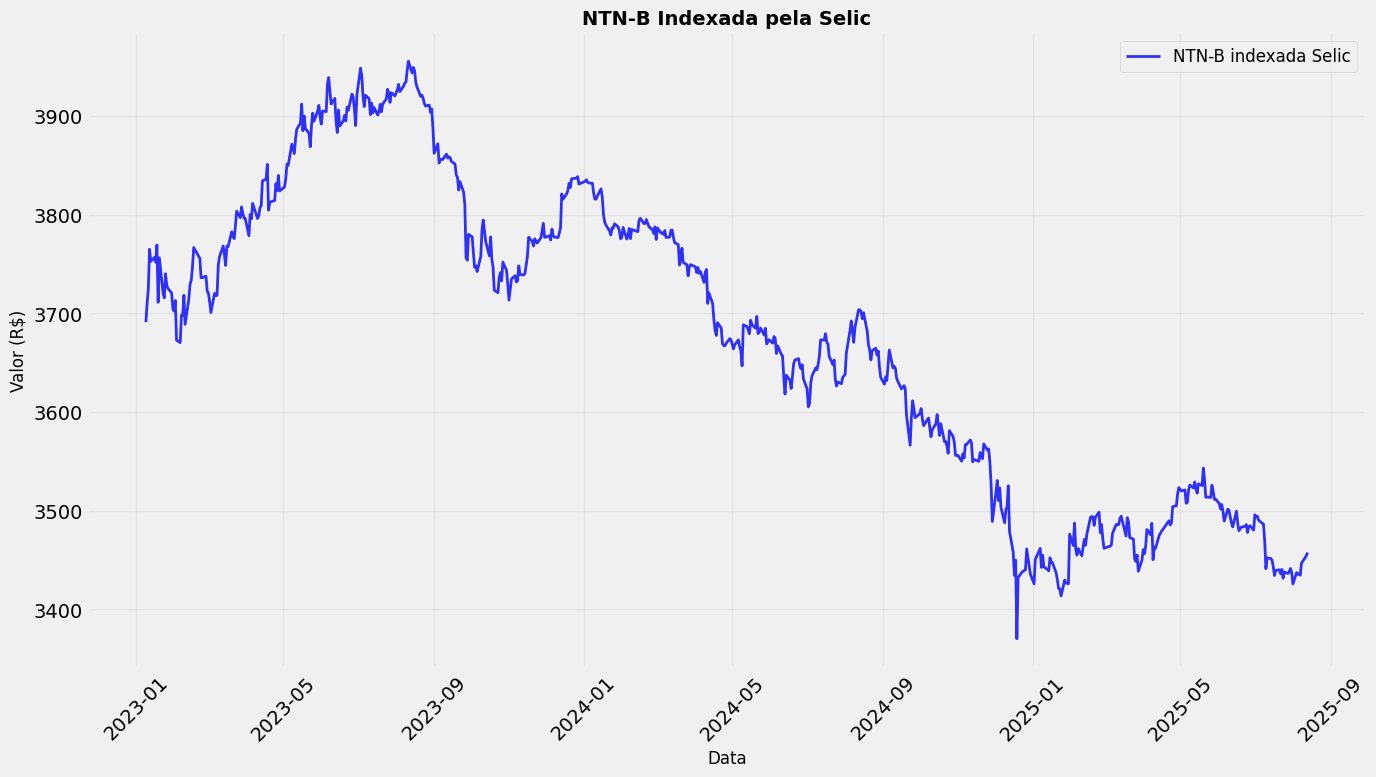


📈 2. ANÁLISE DE TENDÊNCIA (PERÍODO ESPECÍFICO)
----------------------------------------
📈 Analisando tendência (Venc: 15/05/2029) com 500 pontos


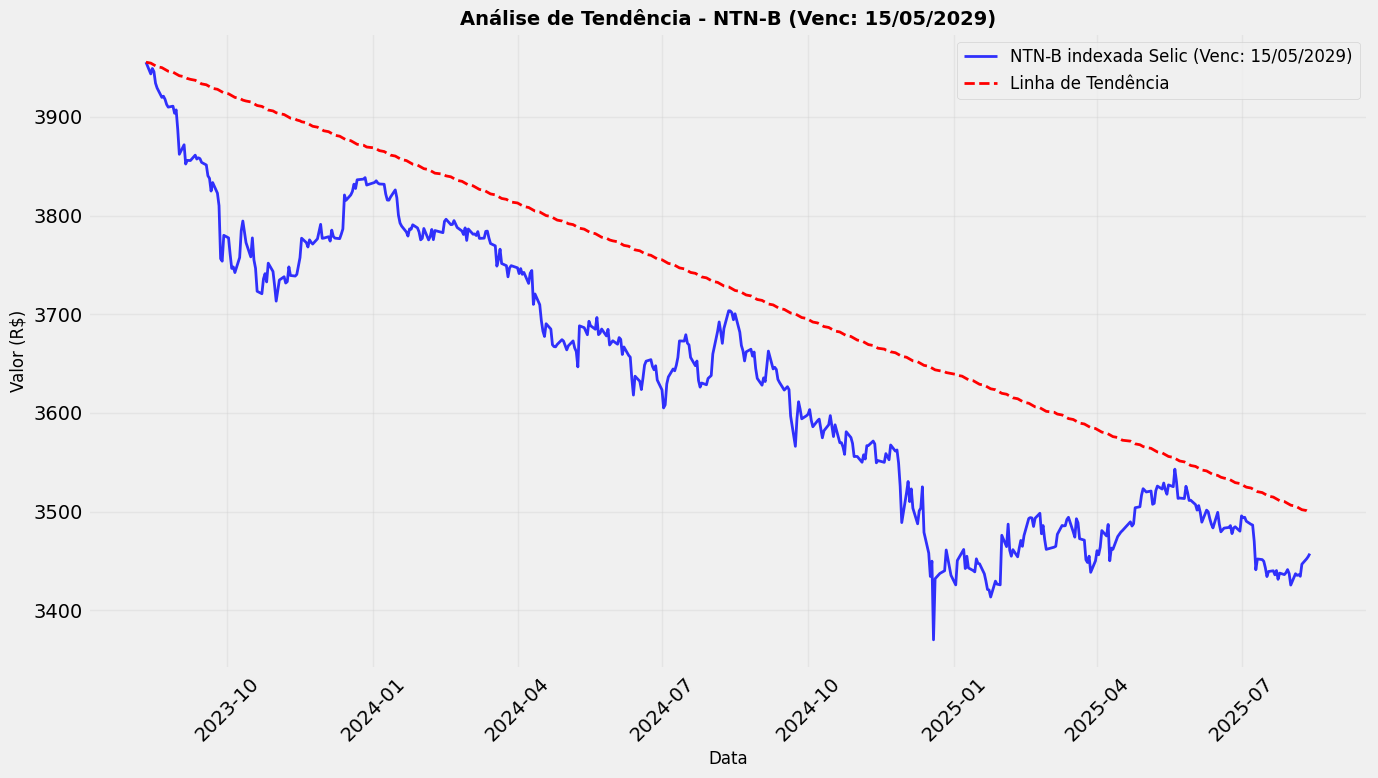

📊 Estatísticas da Tendência:
 • Inclinação: -0.913852
 • R²: 0.8890
 • Valor mínimo: R$ 3370.23 em 19/12/2024
 • Valor máximo: R$ 3955.30 em 11/08/2023

✅ ANÁLISE CONCLUÍDA PARA TÍTULO VENCIMENTO 15/05/2029!


In [ ]:
resultado = analisar_titulo_por_indice(1)

🔍 ANÁLISE CORRIGIDA COM DIAGNÓSTICO:

🔍 DIAGNÓSTICO DOS DADOS
DataFrame IPCA+: 648 registros
DataFrame SELIC: 648 registros
Período IPCA+: 2023-01-09 00:00:00 a 2025-08-13 00:00:00
Período SELIC: 2023-01-09 a 2025-08-13
IPCA+ inicial: R$ 2,725.84 | final: R$ 3,455.64
SELIC inicial: R$ 3,691.01 | final: R$ 3,457.55
📅 Período comum encontrado: 09/01/2023 a 13/08/2025
📊 Dados alinhados: IPCA+(648) | SELIC(648)

📈 RETORNOS NO PERÍODO COMUM:
  IPCA+: +26.77%
  SELIC: -6.33%
  Diferença: +33.10 p.p.

📊 ANÁLISE CORRIGIDA - IPCA+ vs SELIC SIMULADA
Período final analisado: 09/01/2023 a 13/08/2025 (648 dias úteis)

PREÇOS UNITÁRIOS (PERÍODO COMUM):
  IPCA+ inicial: R$ 2,725.84 | final: R$ 3,455.64
  SELIC inicial: R$ 3,691.01 | final: R$ 3,457.55

► SPREAD ANUALIZADO CORRIGIDO: +12.17% ao ano
  ✓ IPCA+ superou a SELIC no período


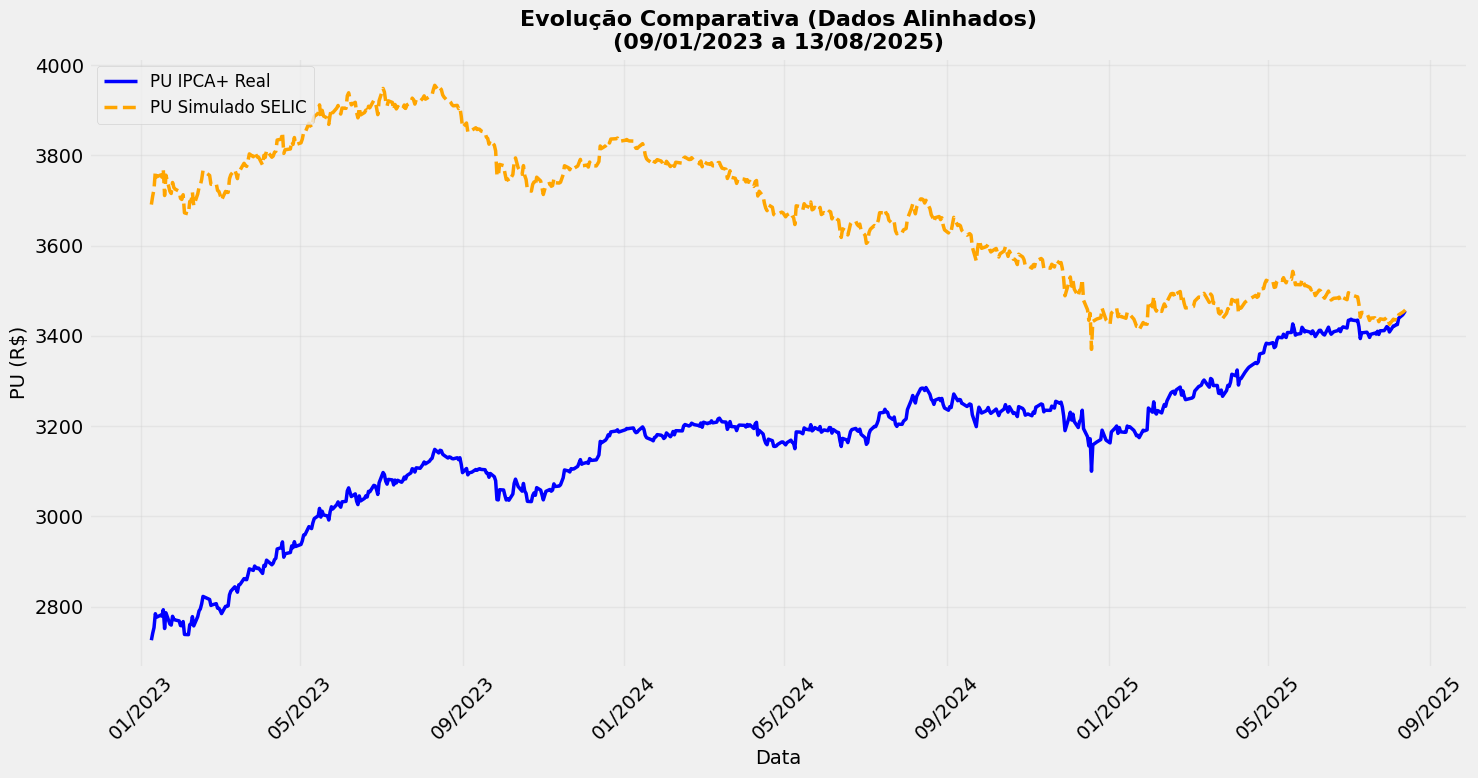

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

def diagnosticar_dados(df_ordenado, df_cdi):
    """
    Diagnóstica problemas nos dados antes da análise.
    """
    print("\n" + "="*60)
    print("🔍 DIAGNÓSTICO DOS DADOS")
    print("="*60)

    # Informações básicas
    print(f"DataFrame IPCA+: {len(df_ordenado)} registros")
    print(f"DataFrame SELIC: {len(df_cdi)} registros")

    # Períodos
    if not df_ordenado.empty:
        inicio_ipca = df_ordenado.index[0] if hasattr(df_ordenado.index, 'date') else df_ordenado.index[0]
        fim_ipca = df_ordenado.index[-1] if hasattr(df_ordenado.index, 'date') else df_ordenado.index[-1]
        print(f"Período IPCA+: {inicio_ipca} a {fim_ipca}")

    if not df_cdi.empty and 'data' in df_cdi.columns:
        inicio_selic = df_cdi['data'].iloc[0]
        fim_selic = df_cdi['data'].iloc[-1]
        print(f"Período SELIC: {inicio_selic.strftime('%Y-%m-%d')} a {fim_selic.strftime('%Y-%m-%d')}")

    # Valores iniciais e finais
    if not df_ordenado.empty:
        pu_ipca_i = df_ordenado.iloc[0]['PU Compra Manha']
        pu_ipca_f = df_ordenado.iloc[-1]['PU Compra Manha']
        print(f"IPCA+ inicial: R$ {pu_ipca_i:,.2f} | final: R$ {pu_ipca_f:,.2f}")

    if not df_cdi.empty:
        pu_selic_i = df_cdi.iloc[0]['VNA_cor']
        pu_selic_f = df_cdi.iloc[-1]['VNA_cor']
        print(f"SELIC inicial: R$ {pu_selic_i:,.2f} | final: R$ {pu_selic_f:,.2f}")

    print("="*60)

def alinhar_dados_por_data(df_ordenado, df_cdi):
    """
    Alinha os DataFrames pelas datas em comum.
    """
    try:
        # Garantir que as datas estão no formato correto
        if 'data' not in df_cdi.columns:
            print("❌ Coluna 'data' não encontrada no DataFrame SELIC")
            return df_ordenado, df_cdi

        # Converter index do df_ordenado para datetime se necessário
        if not pd.api.types.is_datetime64_any_dtype(df_ordenado.index):
            # Se o index não é datetime, tentar converter
            try:
                df_ordenado.index = pd.to_datetime(df_ordenado.index)
            except:
                print("⚠️ Não foi possível converter index do IPCA+ para datetime")
                return df_ordenado, df_cdi

        # Garantir que a coluna data do CDI é datetime
        df_cdi['data'] = pd.to_datetime(df_cdi['data'])

        # Encontrar período comum
        data_inicio_comum = max(df_ordenado.index.min(), df_cdi['data'].min())
        data_fim_comum = min(df_ordenado.index.max(), df_cdi['data'].max())

        print(f"📅 Período comum encontrado: {data_inicio_comum.strftime('%d/%m/%Y')} a {data_fim_comum.strftime('%d/%m/%Y')}")

        # Filtrar ambos DataFrames para o período comum
        df_ordenado_alinhado = df_ordenado[(df_ordenado.index >= data_inicio_comum) &
                                         (df_ordenado.index <= data_fim_comum)]

        df_cdi_alinhado = df_cdi[(df_cdi['data'] >= data_inicio_comum) &
                                (df_cdi['data'] <= data_fim_comum)]

        print(f"📊 Dados alinhados: IPCA+({len(df_ordenado_alinhado)}) | SELIC({len(df_cdi_alinhado)})")

        return df_ordenado_alinhado, df_cdi_alinhado

    except Exception as e:
        print(f"❌ Erro no alinhamento: {e}")
        return df_ordenado, df_cdi

def calcular_spread_corrigido(df_ordenado, df_cdi):
    """
    Calcula o spread com validação extra.
    """
    try:
        if df_ordenado.empty or df_cdi.empty:
            return None

        # Usar dados alinhados por período
        df_ordenado_align, df_cdi_align = alinhar_dados_por_data(df_ordenado, df_cdi)

        if df_ordenado_align.empty or df_cdi_align.empty:
            print("❌ Não há dados em período comum")
            return None

        pu_ipca_inicial = df_ordenado_align.iloc[0]['PU Compra Manha']
        pu_ipca_final = df_ordenado_align.iloc[-1]['PU Compra Manha']
        pu_selic_inicial = df_cdi_align.iloc[0]['VNA_cor']
        pu_selic_final = df_cdi_align.iloc[-1]['VNA_cor']

        # Calcular retornos individuais
        ret_ipca = (pu_ipca_final / pu_ipca_inicial) - 1
        ret_selic = (pu_selic_final / pu_selic_inicial) - 1

        n_uteis = len(df_cdi_align)

        print(f"\n📈 RETORNOS NO PERÍODO COMUM:")
        print(f"  IPCA+: {ret_ipca*100:+.2f}%")
        print(f"  SELIC: {ret_selic*100:+.2f}%")
        print(f"  Diferença: {(ret_ipca - ret_selic)*100:+.2f} p.p.")

        # Spread anualizado
        if pu_selic_final <= 0 or n_uteis <= 0:
            return None

        # Fórmula corrigida: comparar retornos anualizados
        ret_ipca_anual = (1 + ret_ipca) ** (252 / n_uteis) - 1
        ret_selic_anual = (1 + ret_selic) ** (252 / n_uteis) - 1
        spread_anual = (ret_ipca_anual - ret_selic_anual) * 100

        return spread_anual, df_ordenado_align, df_cdi_align

    except Exception as e:
        print(f"❌ Erro no cálculo do spread: {e}")
        return None

def analisar_performance_corrigido(resultado, data_inicio=None, data_fim=None, mostrar_grafico=True):
    """
    Análise corrigida com diagnóstico completo.
    """

    # Extrai DataFrames
    df_ordenado = resultado['dados_completos']['df_ntnb']
    df_cdi = resultado['dados_completos']['df_cdi']

    # Diagnóstico inicial
    diagnosticar_dados(df_ordenado, df_cdi)

    # Filtrar por período se especificado
    if data_inicio is not None or data_fim is not None:
        df_ordenado, df_cdi = filtrar_dados_por_periodo(df_ordenado, df_cdi, data_inicio, data_fim)

    # Cálculo corrigido
    resultado_calculo = calcular_spread_corrigido(df_ordenado, df_cdi)

    if resultado_calculo is None:
        print("❌ Não foi possível realizar a análise")
        return None

    spread_corrigido, df_ord_final, df_cdi_final = resultado_calculo

    # Informações do período final
    data_inicio_real = df_cdi_final['data'].iloc[0].date()
    data_fim_real = df_cdi_final['data'].iloc[-1].date()
    dias_uteis = len(df_cdi_final)

    print("\n" + "="*80)
    print("📊 ANÁLISE CORRIGIDA - IPCA+ vs SELIC SIMULADA")
    print("="*80)
    print(f"Período final analisado: {data_inicio_real.strftime('%d/%m/%Y')} a {data_fim_real.strftime('%d/%m/%Y')} ({dias_uteis} dias úteis)")

    # Valores finais
    pu_ipca_i = df_ord_final.iloc[0]['PU Compra Manha']
    pu_ipca_f = df_ord_final.iloc[-1]['PU Compra Manha']
    pu_selic_i = df_cdi_final.iloc[0]['VNA_cor']
    pu_selic_f = df_cdi_final.iloc[-1]['VNA_cor']

    print(f"\nPREÇOS UNITÁRIOS (PERÍODO COMUM):")
    print(f"  IPCA+ inicial: R$ {pu_ipca_i:,.2f} | final: R$ {pu_ipca_f:,.2f}")
    print(f"  SELIC inicial: R$ {pu_selic_i:,.2f} | final: R$ {pu_selic_f:,.2f}")

    if spread_corrigido is not None:
        print(f"\n► SPREAD ANUALIZADO CORRIGIDO: {spread_corrigido:+.2f}% ao ano")
        if spread_corrigido > 0:
            print("  ✓ IPCA+ superou a SELIC no período")
        else:
            print("  ✗ IPCA+ ficou abaixo da SELIC no período")

    print("="*80)

    # Gráfico se solicitado
    if mostrar_grafico and not df_ord_final.empty and not df_cdi_final.empty:
        plt.figure(figsize=(15, 8))

        plt.plot(df_ord_final.index, df_ord_final["PU Compra Manha"],
                 label="PU IPCA+ Real", color="blue", lw=2.5)
        plt.plot(df_cdi_final["data"], df_cdi_final["VNA_cor"],
                 label="PU Simulado SELIC", color="orange", lw=2.5, linestyle="--")

        titulo = f"Evolução Comparativa (Dados Alinhados)\n({data_inicio_real.strftime('%d/%m/%Y')} a {data_fim_real.strftime('%d/%m/%Y')})"
        plt.title(titulo, fontsize=16, fontweight='bold')
        plt.xlabel("Data", fontsize=14)
        plt.ylabel("PU (R$)", fontsize=14)
        plt.legend(fontsize=12, loc='upper left')
        plt.grid(True, alpha=0.3)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return {
        'spread_corrigido': spread_corrigido,
        'dados_alinhados': {
            'df_ordenado': df_ord_final,
            'df_cdi': df_cdi_final
        },
        'periodo_comum': {
            'inicio': data_inicio_real,
            'fim': data_fim_real,
            'dias_uteis': dias_uteis
        }
    }

# Usar a função anterior para filtrar dados
def filtrar_dados_por_periodo(df_ordenado, df_cdi, data_inicio=None, data_fim=None):
    """Mantém a função anterior de filtro"""
    if isinstance(data_inicio, str):
        data_inicio = pd.to_datetime(data_inicio)
    if isinstance(data_fim, str):
        data_fim = pd.to_datetime(data_fim)

    if data_inicio is None and data_fim is None:
        return df_ordenado.copy(), df_cdi.copy()

    df_ordenado_work = df_ordenado.copy()
    df_cdi_work = df_cdi.copy()

    if hasattr(df_ordenado_work.index, 'date') or pd.api.types.is_datetime64_any_dtype(df_ordenado_work.index):
        if data_inicio is not None:
            df_ordenado_work = df_ordenado_work[df_ordenado_work.index >= data_inicio]
        if data_fim is not None:
            df_ordenado_work = df_ordenado_work[df_ordenado_work.index <= data_fim]

    if 'data' in df_cdi_work.columns:
        df_cdi_work['data'] = pd.to_datetime(df_cdi_work['data'])
        if data_inicio is not None:
            df_cdi_work = df_cdi_work[df_cdi_work['data'] >= data_inicio]
        if data_fim is not None:
            df_cdi_work = df_cdi_work[df_cdi_work['data'] <= data_fim]

    return df_ordenado_work, df_cdi_work

# ===============================
# EXECUTAR ANÁLISE CORRIGIDA
# ===============================

print("🔍 ANÁLISE CORRIGIDA COM DIAGNÓSTICO:")
resultado_corrigido = analisar_performance_corrigido(resultado)

